In [1]:
import scipy.io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import genfromtxt
from aux_functions2 import xavier_init
from aux_functions2 import plot #MINE

import csv
import sys

In [2]:
steps = 20000 # int(sys.argv[1])  # number of training steps
iteration = 10 # int(sys.argv[2])  # number of iterations (iid runs)
d = 50 # int(sys.argv[3])  # dimension of the distributions
mb_size = 40000 # int(sys.argv[4])  # batch size
N = 300000
rho_range = [0.1, 0.3, 0.5, 0.7, 0.9]
lam_gp = 0.1  # gradient penalty constant: \lambda_{gp}

print(steps)
print(iteration)
print(d)
print(mb_size)
print(N)


20000
10
50
40000
300000


In [3]:
# hyperparameters
if d==4:
    layers = [d, 8, 8, 4, 1]
elif d==20:
    layers = [d, 32, 32, 16, 1]
elif d==50:
    layers = [d, 32, 32, 16, 1] # [d, 64, 64, 32, 1]
else:                      
    print('check dimension!')

lam = 1.0 # lambda=beta+gamma

# initialize
X = tf.placeholder(tf.float32, shape=[None, d])
Y = tf.placeholder(tf.float32, shape=[None, d])

def initialize_NN(layers):
    NN_W = []
    NN_b = []
    num_layers = len(layers)
    for l in range(0,num_layers-1):
        W = tf.Variable(xavier_init(size=[layers[l], layers[l+1]]), name="W")
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        NN_W.append(W)
        NN_b.append(b)
    return NN_W, NN_b

D_W, D_b = initialize_NN(layers)

theta_D = [D_W, D_b] 


In [4]:
def discriminator(x):
    num_layers = len(D_W) + 1
    
    h = x  
    for l in range(0,num_layers-2):
        W = D_W[l]
        b = D_b[l]
        h = tf.tanh(tf.add(tf.matmul(h, W), b))
    
    W = D_W[-1]
    b = D_b[-1]
    #out = 50.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 50.0)
    out =  tf.add(tf.matmul(h, W), b)   # unbounded!

    return out

D_real = discriminator(X)
D_fake = discriminator(Y)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

SF = 1000
D_loss_vals =  np.zeros(shape=(len(rho_range), iteration)) 
RD_exact_rho =  np.zeros(shape= len(rho_range))


In [6]:

# estimate Renyi divergence

# Loop over #samples, then over iid iterations and then over training steps
for j, rho in enumerate(rho_range): 
    
    print('j=', j)
    print('rho=', rho)
    
    # load data
    fname = 'data/varying_rho_Sigma1_eye_2/d_' + str(d) + '/input_N' + str(N) + '_dim' + str(d) + '/gaussian_d_' + str(d) + '_'
    data = scipy.io.loadmat(fname + 'data_'+str(rho)+'.mat')
    x_ = np.array(data['x'])
    y_ = np.array(data['y'])

    params = scipy.io.loadmat(fname + 'params_'+str(rho)+'.mat')
    alpha = np.array(params['alpha'])
    No_alpha = alpha.shape[0]

    RD_exact = np.array(params['RD_exact']) # contains exact for all alphas. In current datafiles, only one

    
    beta = lam*(1-alpha[0])  #   <----------- choose the first alpha value
    gamma = lam*alpha[0]  #  <---------- choose the first alpha value
    
    #exact value for Renyi (estimated by integral computation)
    RD_exact_rho[j] = RD_exact[0];
    
    # variational representation:
    if beta == 0:
        D_loss_real = -tf.reduce_mean(D_real)
    else:
        max_val = tf.reduce_max((-beta) * D_real)
        D_loss_real = (1.0 / beta) * (tf.log(tf.reduce_mean(tf.exp((-beta) * D_real - max_val))) + max_val)

    if gamma == 0:
        D_loss_fake = tf.reduce_mean(D_fake)

    else:
        max_val = tf.reduce_max((gamma) * D_fake)
        D_loss_fake = (1.0 / gamma) * (tf.log(tf.reduce_mean(tf.exp(gamma * D_fake - max_val))) + max_val)

    D_loss = D_loss_real + D_loss_fake

    # Gradient Penalty
    alpha_gp = tf.random_uniform(shape=[mb_size,1], minval=0., maxval=1.)
    interpolates = X + (alpha_gp*(Y - X)) 
    gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]  
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_mean(tf.math.maximum(tf.zeros([slopes.shape[0]], dtype=tf.float32) ,(slopes-5.))**2)  # Lipschitz with K=5 

    total_loss = D_loss + lam_gp*gradient_penalty

    D_solver = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(total_loss, var_list=theta_D)

    for iter in range(iteration):
        print('Iteration: {}'.format(iter))
        sess.run(tf.global_variables_initializer())

        x = x_[np.random.randint(x_.shape[0], size=int(0.8*x_.shape[0])), :]
        y = y_[np.random.randint(y_.shape[0], size=int(0.8*x_.shape[0])), :]

        # initialize for plotting
        i = 0
        Pl_freq = 10
        D_loss_plot = np.zeros(shape=((np.rint(steps / Pl_freq)).astype(int), 1))  # because we writeout every Pl_freq

        for it in range(steps):
            X_mb = x[np.random.randint(x.shape[0], size=mb_size), :]
            Y_mb = y[np.random.randint(y.shape[0], size=mb_size), :]

            _, D_loss_curr, D_tot_loss = sess.run([D_solver, D_loss, total_loss], feed_dict={X: X_mb, Y: Y_mb})

            if it % Pl_freq == 0:
                D_loss_plot[i] = D_loss_curr
                i += 1

            if it % SF == 0:
                print('Iter: {}'.format(it))
                print('Renyi divergence: {}'.format(-lam*D_loss_curr))
                print()


        D_loss_curr = sess.run(D_loss, feed_dict={X: x, Y: y})
        D_loss_vals[j,iter] = -lam * D_loss_curr

 
    # -----------------------------------------------------------------------------
    # Plotting
    # -----------------------------------------------------------------------------
    if not os.path.exists('data/out_gaussian_Lip_plots/'):
        os.makedirs('data/out_gaussian_Lip_plots/')

    fig = plt.figure()
    #plt.plot(D_loss_plot)
    x_idx = np.linspace(0, steps, num=(np.rint(steps / Pl_freq)).astype(int))
    plt.plot(x_idx, D_loss_plot)
    plt.xlabel('steps')
    plt.ylabel('D loss')
    plt.savefig('data/out_gaussian_Lip_plots/cgan_Dloss' + str(j) + 'rho_' + str(rho) +'.png', bbox_inches='tight')
    plt.close(fig)
   


j= 0
rho= 0.1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iteration: 0
Iter: 0
Renyi divergence: [1.7401762e-06]

Iter: 1000
Renyi divergence: [0.08050168]

Iter: 2000
Renyi divergence: [0.09812915]

Iter: 3000
Renyi divergence: [0.09639859]

Iter: 4000
Renyi divergence: [0.09753203]

Iter: 5000
Renyi divergence: [0.10835934]

Iter: 6000
Renyi divergence: [0.11137629]

Iter: 7000
Renyi divergence: [0.10942197]

Iter: 8000
Renyi divergence: [0.11580086]

Iter: 9000
Renyi divergence: [0.11155176]

Iter: 10000
Renyi divergence: [0.11333799]

Iter: 11000
Renyi divergence: [0.11531055]

Iter: 12000
Renyi divergence: [0.10978031]

Iter: 13000
Renyi divergence: [0.11662662]

Iter: 14000
Renyi divergence: [0.11951697]

Iter: 15000
Renyi divergence: [0.11598611]

Iter: 16000
Renyi divergence: [0.12067616]

Iter: 17000
Renyi divergence: [0.121647]

Iter: 18000
Renyi divergence: [0.12035501]

Iter: 19000
Renyi divergence: [0.11933553]

Iteration: 

Iter: 18000
Renyi divergence: [0.12318921]

Iter: 19000
Renyi divergence: [0.12231064]

Iteration: 9
Iter: 0
Renyi divergence: [9.313226e-08]

Iter: 1000
Renyi divergence: [0.07530212]

Iter: 2000
Renyi divergence: [0.09667146]

Iter: 3000
Renyi divergence: [0.10260534]

Iter: 4000
Renyi divergence: [0.10773516]

Iter: 5000
Renyi divergence: [0.10756278]

Iter: 6000
Renyi divergence: [0.10935652]

Iter: 7000
Renyi divergence: [0.11517435]

Iter: 8000
Renyi divergence: [0.11685884]

Iter: 9000
Renyi divergence: [0.11812532]

Iter: 10000
Renyi divergence: [0.10937667]

Iter: 11000
Renyi divergence: [0.11757624]

Iter: 12000
Renyi divergence: [0.11463428]

Iter: 13000
Renyi divergence: [0.12296009]

Iter: 14000
Renyi divergence: [0.11863828]

Iter: 15000
Renyi divergence: [0.11896229]

Iter: 16000
Renyi divergence: [0.12412298]

Iter: 17000
Renyi divergence: [0.1213367]

Iter: 18000
Renyi divergence: [0.11901462]

Iter: 19000
Renyi divergence: [0.12863934]

j= 1
rho= 0.3
Iteration: 0
Iter

Iter: 6000
Renyi divergence: [0.7973232]

Iter: 7000
Renyi divergence: [0.80730677]

Iter: 8000
Renyi divergence: [0.7995925]

Iter: 9000
Renyi divergence: [0.80202293]

Iter: 10000
Renyi divergence: [0.8201103]

Iter: 11000
Renyi divergence: [0.81738853]

Iter: 12000
Renyi divergence: [0.8196659]

Iter: 13000
Renyi divergence: [0.82061696]

Iter: 14000
Renyi divergence: [0.81729054]

Iter: 15000
Renyi divergence: [0.83256054]

Iter: 16000
Renyi divergence: [0.8242607]

Iter: 17000
Renyi divergence: [0.83410525]

Iter: 18000
Renyi divergence: [0.8264165]

Iter: 19000
Renyi divergence: [0.8337579]

Iteration: 9
Iter: 0
Renyi divergence: [2.6619527e-06]

Iter: 1000
Renyi divergence: [0.6788764]

Iter: 2000
Renyi divergence: [0.7068219]

Iter: 3000
Renyi divergence: [0.7495589]

Iter: 4000
Renyi divergence: [0.75846624]

Iter: 5000
Renyi divergence: [0.7729373]

Iter: 6000
Renyi divergence: [0.7611437]

Iter: 7000
Renyi divergence: [0.7677603]

Iter: 8000
Renyi divergence: [0.7670467]

It

Iter: 17000
Renyi divergence: [2.7881489]

Iter: 18000
Renyi divergence: [2.7286358]

Iter: 19000
Renyi divergence: [2.7038298]

Iteration: 8
Iter: 0
Renyi divergence: [-1.8947758e-06]

Iter: 1000
Renyi divergence: [2.2173653]

Iter: 2000
Renyi divergence: [2.3244853]

Iter: 3000
Renyi divergence: [2.3445606]

Iter: 4000
Renyi divergence: [2.4327097]

Iter: 5000
Renyi divergence: [2.5290947]

Iter: 6000
Renyi divergence: [2.4991145]

Iter: 7000
Renyi divergence: [2.555719]

Iter: 8000
Renyi divergence: [2.5421066]

Iter: 9000
Renyi divergence: [2.569049]

Iter: 10000
Renyi divergence: [2.5990815]

Iter: 11000
Renyi divergence: [2.5559998]

Iter: 12000
Renyi divergence: [2.5656567]

Iter: 13000
Renyi divergence: [2.562293]

Iter: 14000
Renyi divergence: [2.5599513]

Iter: 15000
Renyi divergence: [2.5747204]

Iter: 16000
Renyi divergence: [2.567874]

Iter: 17000
Renyi divergence: [2.5709162]

Iter: 18000
Renyi divergence: [2.5954766]

Iter: 19000
Renyi divergence: [2.5606923]

Iteration:

Iter: 9000
Renyi divergence: [8.000858]

Iter: 10000
Renyi divergence: [7.9490147]

Iter: 11000
Renyi divergence: [7.9201083]

Iter: 12000
Renyi divergence: [7.9344735]

Iter: 13000
Renyi divergence: [7.9290876]

Iter: 14000
Renyi divergence: [7.973338]

Iter: 15000
Renyi divergence: [7.917551]

Iter: 16000
Renyi divergence: [7.9850197]

Iter: 17000
Renyi divergence: [7.909316]

Iter: 18000
Renyi divergence: [8.017369]

Iter: 19000
Renyi divergence: [7.821405]

Iteration: 8
Iter: 0
Renyi divergence: [2.7474016e-06]

Iter: 1000
Renyi divergence: [6.1052065]

Iter: 2000
Renyi divergence: [6.4900875]

Iter: 3000
Renyi divergence: [6.7053986]

Iter: 4000
Renyi divergence: [7.006217]

Iter: 5000
Renyi divergence: [7.0540195]

Iter: 6000
Renyi divergence: [7.052019]

Iter: 7000
Renyi divergence: [7.070486]

Iter: 8000
Renyi divergence: [7.150099]

Iter: 9000
Renyi divergence: [7.1062284]

Iter: 10000
Renyi divergence: [7.1230955]

Iter: 11000
Renyi divergence: [7.122953]

Iter: 12000
Renyi d

Iteration: 7
Iter: 0
Renyi divergence: [8.1490725e-10]

Iter: 1000
Renyi divergence: [16.347904]

Iter: 2000
Renyi divergence: [19.48902]

Iter: 3000
Renyi divergence: [20.687744]

Iter: 4000
Renyi divergence: [21.688457]

Iter: 5000
Renyi divergence: [22.102707]

Iter: 6000
Renyi divergence: [22.67974]

Iter: 7000
Renyi divergence: [22.673458]

Iter: 8000
Renyi divergence: [22.692509]

Iter: 9000
Renyi divergence: [22.896677]

Iter: 10000
Renyi divergence: [23.145344]

Iter: 11000
Renyi divergence: [23.047302]

Iter: 12000
Renyi divergence: [23.01889]

Iter: 13000
Renyi divergence: [23.050236]

Iter: 14000
Renyi divergence: [23.131985]

Iter: 15000
Renyi divergence: [23.296005]

Iter: 16000
Renyi divergence: [23.305473]

Iter: 17000
Renyi divergence: [23.287209]

Iter: 18000
Renyi divergence: [23.307833]

Iter: 19000
Renyi divergence: [23.455635]

Iteration: 8
Iter: 0
Renyi divergence: [1.635286e-06]

Iter: 1000
Renyi divergence: [13.534333]

Iter: 2000
Renyi divergence: [15.245261]



In [7]:
print(D_loss_vals)

[[ 0.12214744  0.12003493  0.12008226  0.11978841  0.11885571  0.12210155
   0.11875772  0.11659622  0.11926794  0.12320578]
 [ 0.82852364  0.8400774   0.83107114  0.83106518  0.80153131  0.84778833
   0.85131884  0.84617138  0.82765913  0.7817421 ]
 [ 2.74280643  2.65938735  2.65539455  2.51191473  2.65689898  2.4113636
   2.4925499   2.7354269   2.5731473   2.57402277]
 [ 5.64835882  7.20140409  7.44172668  7.48901272  6.28740501  7.50381756
   7.47060394  8.01401424  7.17234182  6.57436419]
 [23.8199501  26.76161575 18.23361969 16.36691284 31.0743866  13.56995773
  24.99056244 23.47511673 18.25178146 20.69285583]]


In [8]:
   

with open('data/out_gaussian_Lip_plots/'+'lambda_'+str(lam)+'_bs_'+str(mb_size)+'_nerd_'+str(rho)+'.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in D_loss_vals:
        writer.writerow(val)


Text(0, 0.5, 'divergence')

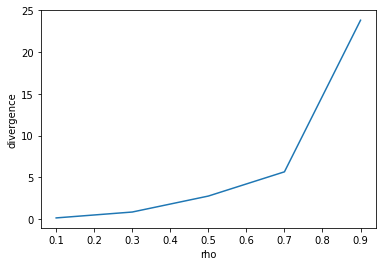

In [9]:
# Plot RD vs rho
#======================
fig = plt.figure()
plt.plot(rho_range, D_loss_vals[:,0])
plt.xlabel('rho')
plt.ylabel('divergence')

(0.0, 40.0)

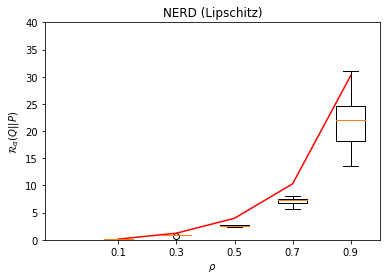

In [10]:


fig1, ax1 = plt.subplots()
ax1.set_title('NERD (Lipschitz)')
ax1.boxplot(np.transpose(D_loss_vals[:,:]) , labels=[0.1, 0.3, 0.5, 0.7, 0.9], whis=2)
ax1.plot(np.arange(1,len(rho_range)+1), RD_exact_rho[:],'r', 'LineWidth', 2 );
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\mathcal{R}_{\alpha}(Q||P)$')
plt.ylim(0.0, 40.0)




In [ ]:
print('program terminated succesfully')